<a href="https://colab.research.google.com/github/alessiomuscillo/modeling_waves/blob/main/Code_for_Mazzisi_et_al_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Mazzarisi et al 2024

This code is for the paper "The Rise and Fall of Ideas’ Popularity" (2024) by Piero Mazzarisi, Alessio Muscillo, Claudio Pacati and Paolo Pin.

# IMPORTS & LOADS

## Imports

In [11]:
!pip install pytrends
!pip install dtaidistance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pytrends.request import TrendReq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq
from matplotlib import rc
from datetime import timedelta, datetime
import scipy
import pickle
import os

from dtaidistance import dtw
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize

folder = "/content/drive/MyDrive/RICERCA/Waves/data/"

## Loads

Here you can load directly the data, if you do not want to execute the time-consuming parts of the code where the data from Google Trends are fetched and where the distence from 500 random walks is computed for every word.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
# directly load Google Trends, if you do not want to execute the blocks the time-consuming part of code where results is computed
# this dataframe is created in section "GOOGLE TRENDS / Fetching data"
df_trends = pd.read_excel(folder + "df_trends_top1000words.xlsx")
df_trends.head()

In [ ]:
# # load results
# # this dataset is created in section "RANDOM PATHS / Distance to random paths / Save"
# with open(folder + 'results.pkl', 'rb') as f:
#     results = pickle.load(f)

# WORDS TO ANALYZE

From Data For SEO: https://dataforseo.com/free-seo-stats/top-1000-keywords

In [ ]:
top_words = pd.read_csv(folder + "top_keywords_sv.csv", on_bad_lines='skip', sep=';')['Keyword'].values
top_words[:50]

array(['youtube', 'restaurant', 'yahoo mail', 'fox news', 'ebay',
       'google maps', 'weather tomorrow', 'costco', 'macys', 'netflix',
       'google docs', 'map', 'reddit', 'pizza hut', "sam's club",
       'linkedin', 'roblox', 'costco wholesale corporation',
       'taylor swift', "wendy's", 'solitaire', 'mlb score', 'autozone',
       'aol mail', 'pinterest', 'facebook login', 'aa airlines',
       'fedex track', 'powerball', 'google drive', 'planet fitness',
       'dow jones industrial index', 'g drive', 'swa airlines', 'aldi',
       'federal express tracking', 'ufc', 'burger king', 'daily mail',
       'weather 10 days', 'breakfast', 'chase', 'ups', 'grocery stores',
       'nordstrom', 'cvs near me', 'jcpenney', 'chinese food near me',
       'liga mx', 'bing'], dtype=object)

# GOOGLE TRENDS

## Fetching data

In [ ]:
# Keywords to analyze
keywords = words_to_fetch

In [ ]:
len(keywords)

1000

In [ ]:
# Initialize pytrends with delay between requests
pytrends = TrendReq(hl='en-US', tz=360)

# Define a function to fetch data with a delay for individual words
def fetch_trends_data(word, retries=5, delay=10):
    """
    Fetches Google Trends data for a single keyword with retry and delay handling for rate limits.
    :param word: Single keyword to fetch data for.
    :param retries: Number of retry attempts.
    :param delay: Delay between requests in seconds.
    :return: DataFrame with Google Trends data for the keyword.
    """
    attempt = 0
    while attempt < retries:
        try:
            pytrends.build_payload([word], timeframe='today 5-y', geo='', gprop='')
            trends_data = pytrends.interest_over_time()
            return trends_data
        except Exception as e:
            print(f"Error fetching data for '{word}': {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
            attempt += 1
    return None

In [ ]:
# Fetch data
# Initialize an empty dictionary to store data for each keyword
trends_dict = {}

# Fetch data for each word individually with delay
for word in keywords:
    print(f"Fetching data for '{word}'...")
    trends_data = fetch_trends_data(word)

    # Check if data was fetched successfully
    if trends_data is not None:
        # Drop the 'isPartial' column (not needed for analysis)
        trends_data = trends_data.drop(columns=['isPartial'])
        # Store the data in the dictionary
        trends_dict[word] = trends_data[word]
        print(f"Data for '{word}' fetched successfully.")
    else:
        print(f"Failed to fetch data for '{word}' after retries.")

Fetching data for 'bmi'...
Data for 'bmi' fetched successfully.
Fetching data for 'merrick bank'...
Data for 'merrick bank' fetched successfully.
Fetching data for 'spotify premium'...
Data for 'spotify premium' fetched successfully.
Fetching data for 'spelling bee nyt'...
Data for 'spelling bee nyt' fetched successfully.
Fetching data for 'chili's menu'...
Data for 'chili's menu' fetched successfully.
Fetching data for 'vietnamese restaurant'...
Data for 'vietnamese restaurant' fetched successfully.
Fetching data for 'baseball scores'...
Data for 'baseball scores' fetched successfully.
Fetching data for 'legoland'...
Data for 'legoland' fetched successfully.
Fetching data for 'solar eclipse 2023'...
Data for 'solar eclipse 2023' fetched successfully.
Fetching data for 'pink eye'...
Data for 'pink eye' fetched successfully.
Fetching data for 'shawarma'...
Data for 'shawarma' fetched successfully.
Fetching data for 'kelsey plum'...
Data for 'kelsey plum' fetched successfully.
Fetching d

KeyError: "['isPartial'] not found in axis"

In [ ]:
# Combine all keyword data into a single DataFrame
combined_data = pd.concat(trends_dict, axis=1).reset_index()
combined_data.head()

In [ ]:
# clean
# Step 1: Get all column names as a list
column_names = combined_data.columns

# Step 2: Check for duplicated column names
duplicated_columns = column_names.duplicated(keep='last')  # Keeps only the last occurrence

# Step 3: Create a new DataFrame that only keeps the last occurrence of the duplicated columns
combined_data = combined_data.loc[:, ~duplicated_columns]

In [ ]:
combined_data = pd.concat([combined_data['date'], combined_data[[w for w in set(combined_data.columns.tolist()) & set(top_words)]]], axis=1)
combined_data.head()

,date,bmi,merrick bank,minecraft,national football league news,spotify premium,chili's menu,spelling bee nyt,vietnamese restaurant,iowa vs south carolina,...,lego,az cardinals,denzel washington,blood pressure chart,chinese food,doberman,allstate,sphere,mila kunis,la casa de los famosos vota
0,2019-09-15,72,75,69,46,46,17,6,72,0,...,27,47,19,65,59,58,84,14,22,0
1,2019-09-22,68,72,65,33,46,17,7,72,0,...,26,49,16,64,59,58,88,14,38,0
2,2019-09-29,69,78,64,41,43,16,5,72,0,...,27,43,16,67,58,58,86,14,28,0
3,2019-10-06,71,82,63,42,45,17,7,75,0,...,29,39,16,66,60,56,88,16,21,0
4,2019-10-13,66,82,54,43,41,16,9,70,0,...,28,47,17,61,60,60,82,14,18,0


In [ ]:
# # SAVE data
# combined_data.to_excel(folder + "df_trends_top1000words.xlsx", index=False)

## An example: "economy" and "christmas"

Here we analyze two words, "economy" and "christmas". As expected, "christmas" exhibits annual seasonality while "economy" exhibits a wave-like behavior.

In [ ]:
# apply the same code of the previous block "WORDS TO ANALYZE" to these keywords
keywords_2 = ['economy','christmas']

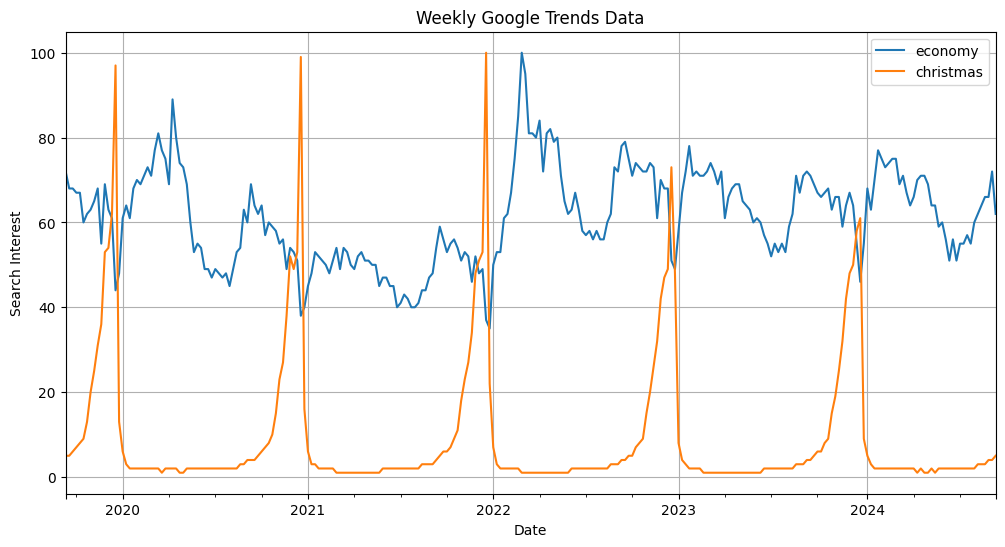

In [ ]:
# Visualize the time series for some example keywords
combined_data.plot(figsize=(12, 6))
plt.title("Weekly Google Trends Data")
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.grid(True)
plt.show()

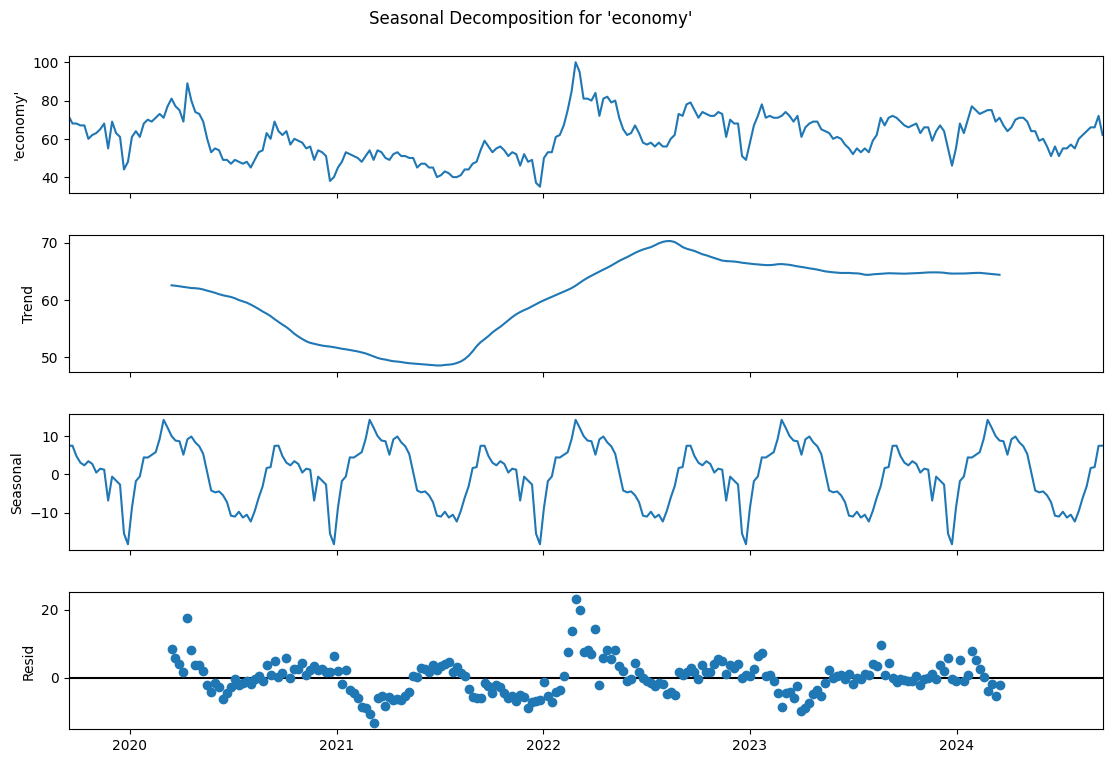

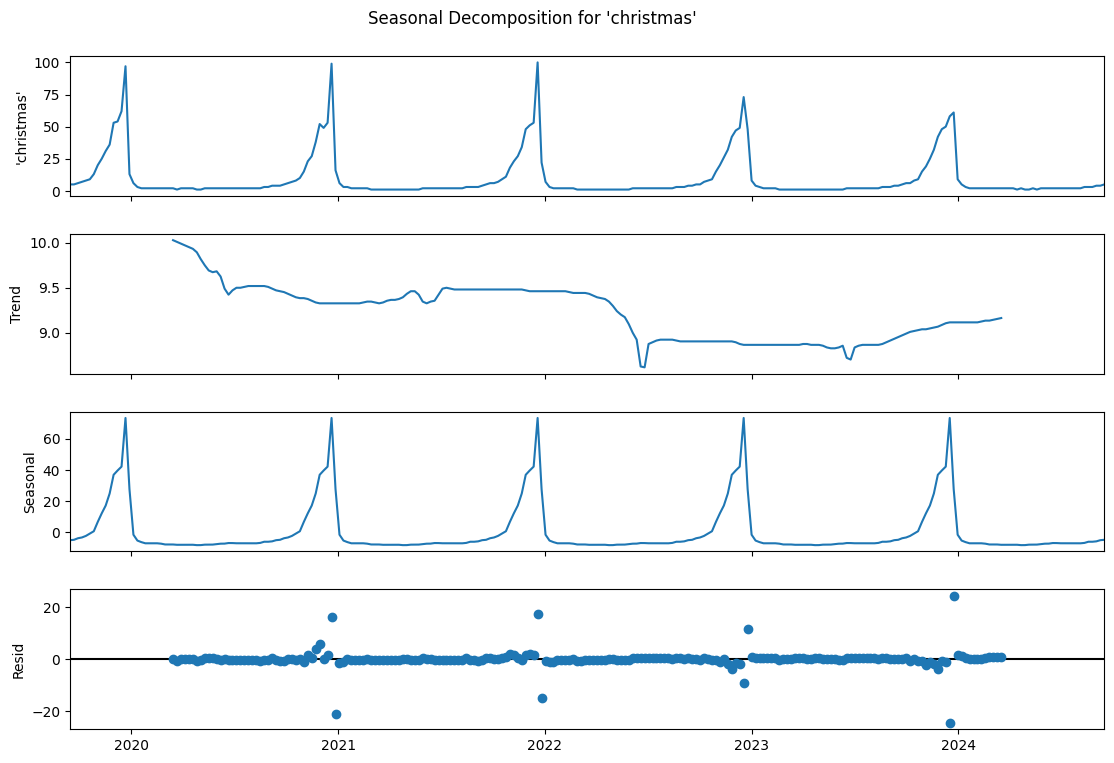

In [ ]:
# Decompose the time series and analyze seasonality for each keyword
for word in keywords:
    decomposition = seasonal_decompose(combined_data[word], model='additive', period=52)  # Annual seasonality for weekly data
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    fig.axes[0].set_title("")
    fig.axes[0].set_ylabel(f"'{word}'")
    plt.suptitle(f"Seasonal Decomposition for '{word}'", fontsize='large')
    plt.show()

# OUR MODEL with different parameters

## Function for our model

In [ ]:
def our_model(beta, xi):

    alpha = beta + xi + np.sqrt(xi*(beta+xi)) + 0.01
    delta = alpha

    # parameters for computations
    T = len(df_trends) + 52
    passi = 1000
    dt = 1.0/passi

    # output parameters
    writeio = False
    outpath  = 'SIRSdetNonStab/'
    filedatiinput = 'input.txt'
    filedatioutput = 'output.txt'
    figext = 'pdf'
    plt.rcParams["savefig.dpi"] = 1200
    plt.rcParams["savefig.bbox"] = 'tight'
    plt.rcParams["savefig.pad_inches"] = 0.0125
    #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    # rc('font',**{'family':'serif','serif':['Garamond']})
    rc('text', usetex=False)

    # initialization
    s0 = 0.9
    i0 = 0.1
    gamma0 = 0.1

    if writeio:
        with open(outpath + filedatiinput, 'w',encoding="utf-8") as f:
            f.write('Deterministic SIRS (gamma time dependent)\n')
            f.write('\n')
            f.write('Modello:\n')
            f.write('ds=(-beta*s*i + xi*(1.0-s-i))*dt\n')
            f.write('di=(beta*s*i-np.exp(lngamma)*i)*dt\n')
            f.write('dlngamma=(alpha*i-delta*s)*dt\n')
            f.write('\n')
            now = datetime.now()
            f.write('Elaborazione: '+now.strftime("%d/%m/%Y %H:%M:%S")+'\n')
            f.write('\n')
            f.write('Parametri in input:\n')
            f.write('beta  = {}\n'.format(beta))
            f.write('xi    = {}\n'.format(xi))
            f.write('alpha = {}\n'.format(alpha))
            f.write('delta = {}\n'.format(delta))
            f.write('\n')
            f.write('Parametri di calcolo:\n')
            f.write('T = {}\n'.format(T))
            f.write('passi = {0} (dt = {1})\n'.format(passi,dt))
            f.write('\n')
            f.write('Inizializzazione delle variabili:\n')
            f.write('s0 = {}\n'.format(s0))
            f.write('i0 = {}\n'.format(i0))
            f.write('gamma0 = {}\n'.format(gamma0))
            f.close()

    # Fixed points
    pf1 = np.array([1,0,0])
    pf2 = np.array([0,1,0])
    radicando = xi*(xi*(alpha+delta)**2+4*alpha*beta*delta)
    coeff = (-xi*(alpha+delta)+np.sqrt(radicando))/2
    pf3 = coeff*np.array([1.0/(beta*delta),1.0/(alpha*beta),1.0/delta])
    a3 = -1.0
    a2 = -(beta*pf3[1]+xi)
    a1 = -(alpha*pf3[2]+beta**2*pf3[0]+beta*xi)*pf3[1]
    a0 = -(beta*delta*pf3[0]+delta*xi+alpha*beta*pf3[1]+alpha*xi)*pf3[2]*pf3[1]
    coeffcharpoly = np.array([a0,a1,a2,a3])
    charpoly = np.polynomial.polynomial.Polynomial(coeffcharpoly)
    eigenvalues = charpoly.roots()
    eigen_neg_real_part = True
    for eigen in eigenvalues:
        eigen_neg_real_part = eigen_neg_real_part and (eigen.real<0.0)

    def cond(a):
        lhs = a[2]*a[1]
        rhs = a[3]*a[0]
        return [lhs,rhs]
    def condb(a):
        [lhs,rhs] = cond(a)
        return lhs>rhs
    def conds(a):
        [lhs,rhs] = cond(a)
        return '{0} > {1}: {2}'.format(lhs,rhs,condb(a))
    def cond11():
        lhs = alpha
        rhs = 2*(beta+xi)*beta/(2*beta+xi)
        return [lhs,rhs]
    def cond11b():
        [lhs,rhs] = cond11()
        return lhs<rhs
    def cond11s():
        [lhs,rhs] = cond11()
        return '{0} < {1} ({2})'.format(lhs,rhs,cond11b())
    def cond12():
        lhs = delta
        rhs = alpha**2*xi/(2*(beta+xi)*beta-alpha*(2*beta+xi))
        return [lhs,rhs]
    def cond12b():
        [lhs,rhs] = cond12()
        return lhs>=rhs
    def cond12s():
        [lhs,rhs] = cond12()
        return '{0} ≥ {1} ({2})'.format(lhs,rhs,cond12b())
    def cond1b():
        return cond11b() and cond12b()
    def cond1s():
        return '{0} and {1}: {2}'.format(cond11s(),cond12s(),cond1b())
    def cond2():
        a = beta
        b = alpha
        c = beta + xi
        return [a,b,c]
    def cond2b():
        data = cond2()
        return data[0]<=data[1] and data[1]<=data[2]
    def cond2s():
        [a,b,c] = cond2()
        return '{0} ≤ {1} ≤ {2}: {3}'.format(a,b,c,cond2b())
    def cond3():
        lhs = delta
        den = ((alpha-beta)*(alpha-beta-xi))
        if den==0.0:
            rhs = float("inf")
        else:
            rhs = alpha**2*xi/((alpha-beta)*(alpha-beta-xi))
        return [lhs,rhs]
    def cond3b():
        [lhs,rhs] = cond3()
        return lhs<rhs
    def cond3s():
        [lhs,rhs] = cond3()
        return '{0} < {1}: {2}'.format(lhs,rhs,cond3b())

    # Solution of the model
    from scipy.integrate import solve_ivp
    tempi = np.linspace(0,T,T*passi+1,endpoint=True,dtype=float)
    def sirs2_model(t,y,beta,xi,alpha,delta):
        return [-beta*y[0]*y[1] + xi*(1.0-y[0]-y[1]),beta*y[0]*y[1]-np.exp(y[2])*y[1],alpha*y[1]-delta*y[0]]
    sol = solve_ivp(sirs2_model, [0, T], [s0,i0,np.log(gamma0)], t_eval=tempi, method='RK45',args=(beta,xi,alpha,delta))

    # plot solution
    model = sol.y[0]
    model = [model[i*passi] for i in range(0, T)]
    return model

## Plot our models

### Set parameters

Parameters of the model are set as follows:
- $\xi = 0.1$
- $\alpha = \beta+\xi+\sqrt{\xi(\beta+\xi)} + 0.01$
- and $\beta \in [0.01, 0.3]$

In [ ]:
# set parameters
xi = 0.1
betas = np.round(np.arange(.01,.31,.01),2)
betas

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])

### Plot our models

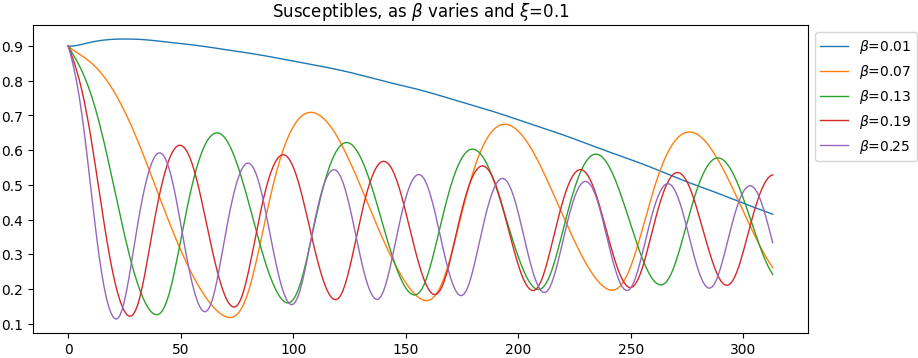

In [ ]:
# plot our model with some betas
plt.figure(figsize=(10, 4))
for beta in betas[::6]:
    plt.plot(our_model(beta, xi), linewidth=1, label=f'$\\beta$={beta}')
plt.legend(bbox_to_anchor=(1,1))
plt.title(f"Susceptibles, as $\\beta$ varies and $\\xi$={xi}")
plt.show()

We want to:
- eliminate the initial "transitional" phase (first 52 steps)
- rescale to have plots between -1 and 1 (to be compared with words' residuals)

In [ ]:
# normalize in range [-1,1]
def normalize(residuals):
    min_val = np.nanmin(residuals)
    max_val = np.nanmax(residuals)
    return 2 * (residuals - min_val) / (max_val - min_val) - 1

In [ ]:
# eliminate first 52 steps and normalize in range [-1,1]
dict_model = dict()
for beta in betas:
    dict_model[beta] = normalize(our_model(beta,xi)[52:])

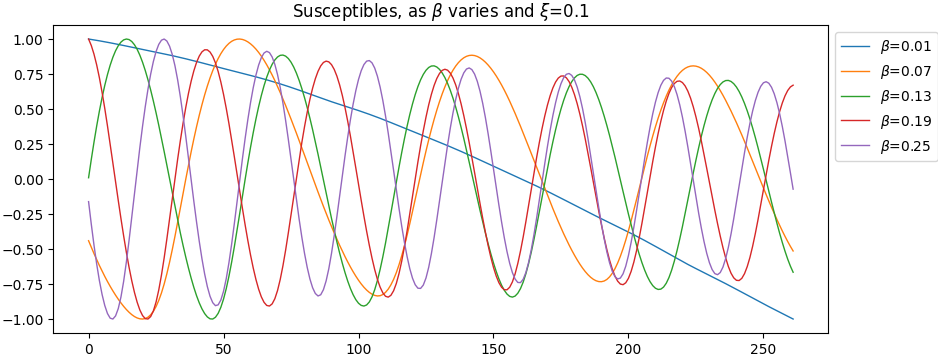

In [ ]:
# rescale model between 0 and 100, also eliminate the first 52 steps (initial transient phase)
xi = 0.1
plt.figure(figsize=(10, 4))
for beta in betas[::6]:
    plt.plot(dict_model[beta],
             linewidth=1, label=f'$\\beta$={beta}')
plt.legend(bbox_to_anchor=(1,1))
plt.title(f"Susceptibles, as $\\beta$ varies and $\\xi$={xi}")
plt.show()

## Find closest model to every word

For every word, find the model (depending on $\beta$) that minimizes the DTW distance between the model($\beta$) and the residuals.

In [ ]:
# Step 1: Function to compute residuals from seasonal decomposition (annual, 52 weeks)
def compute_residuals(series, period=52):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    residuals = decomposition.resid.dropna().values  # Remove NaN values
    return residuals

# Step 2: Function to normalize residuals to the range [-1, 1]
# already defined above

# Step 3: Function to compute the DTW distance between word residuals and the normalized model
def compute_dtw_distance(series, model):
    word_normalized_residuals = normalize(compute_residuals(series))
    min_len = min(len(word_normalized_residuals), len(model))
    return dtw.distance(word_normalized_residuals[:min_len], normalize(model[:min_len]))

In [ ]:
# Step 4: Function to find the beta that minimizes the DTW distance
def find_best_beta(series, betas, dict_model):
    best_beta = None
    min_dtw_distance = float('inf')  # Start with a large number for comparison

    # Iterate over all betas
    for beta in betas:
        model = dict_model[beta]  # Retrieve the model for the current beta

        # Step 3: Compute DTW distance between the residuals of the series and the model
        dtw_distance = compute_dtw_distance(series, model)

        # Check if this beta produces a smaller distance
        if dtw_distance < min_dtw_distance:
            min_dtw_distance = dtw_distance
            best_beta = beta

    return best_beta, min_dtw_distance

### Compute min DTW distance for every word

In [ ]:
how_many_words = len(df_trends.columns) # see block "Loads"
how_many_words

In [ ]:
# Initialize an empty dictionary to store the results for each word
results = {}

# Step 6: Loop through each word (each column except 'date' in df_trends)
for word in df_trends.columns[1:how_many_words]:  # Skip 'date' column, assuming it's the first column
    series = df_trends[word]  # Get the time series for the word

    # Step 1: Compute the residuals for the word
    word_residuals = compute_residuals(series)

    # Step 2: Normalize the residuals
    word_residuals_normalized = normalize(word_residuals)

    # Step 3: Find the best beta for this word by minimizing DTW distance
    best_beta, best_dtw_distance = find_best_beta(series, betas, dict_model)

    # Step 4: Store the results in the dictionary
    results[word] = {'best_beta': best_beta,
                     'min_dtw_distance': np.round(best_dtw_distance, 2),  # Round the DTW distance for easier reading
                     'residuals': word_residuals_normalized}

## An Example

Best beta for 'bmi': 0.27
Minimum DTW distance: 3.66


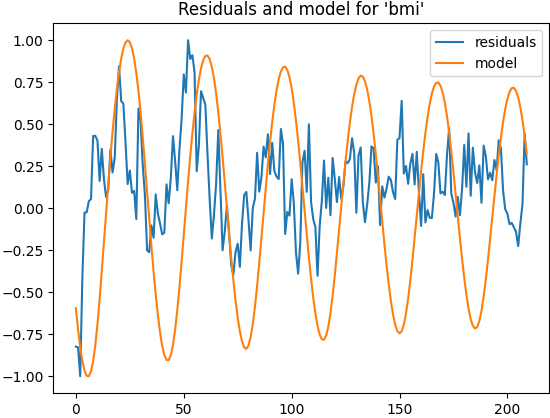

In [ ]:
# Example usage
word = 'bmi'  # Replace this with the actual word

series = df_trends[word]  # Get the time series for the word
best_beta, best_dtw_distance = find_best_beta(series, betas, dict_model)

# Output the best beta and the associated DTW distance
print(f"Best beta for '{word}': {best_beta}")
print(f"Minimum DTW distance: {np.round(best_dtw_distance,2)}")

res = results[word]['residuals']
mod = dict_model[best_beta]
min_len = min(len(res), len(mod))
plt.plot(res[:min_len], label='residuals')
plt.plot(mod[:min_len], label='model')
plt.legend()
plt.title(f"Residuals and model for '{word}'")
plt.show()

# RANDOM PATHS

1. Generate 500 different random walks for every word.
1. Normalize the random walks to range between -1 and 1.
1. Compute the DTW distance between the word's residuals and each of the random walks.
1. Store the random walks and their DTW distances in a dictionary for each word.




In [ ]:
n_walks = 500

## Random walks

In [ ]:
# Step 1: Function to simulate a random walk of a given length
def generate_random_walk(length):
    return np.cumsum(np.random.randn(length))

# Step 2: Function to generate i.i.d. normal paths of a given length
def generate_normal_path(length):
    return np.random.randn(length)  # Independent and identically distributed normal values

# Function to normalize a series to range [-1, 1]
def normalize(series):
    min_val = np.min(series)
    max_val = np.max(series)
    return 2 * (series - min_val) / (max_val - min_val) - 1

# Step 3: Function to compute the DTW distance between a word's residuals and random walks or normal paths
def dtw_distance_to_residuals(residuals, generated_paths):
    dtw_distances = []

    for path in generated_paths:
        min_len = min(len(residuals), len(path))  # Ensure lengths match for DTW
        dtw_distance = dtw.distance(residuals[:min_len], path[:min_len])
        dtw_distances.append(dtw_distance)

    return dtw_distances  # Return the list of DTW distances

## Distance to random paths

In [ ]:
# Loop through each word, generate random walks and normal paths, compute DTW, and store results

for word in df_trends.columns.tolist()[1:how_many_words]:  # Iterate through all words in df_trends
    series = df_trends[word]  # Get the time series for the word

    # Step 1: Compute the residuals for the word (assuming you already have the residuals computed)
    word_residuals = compute_residuals(series)
    word_residuals_normalized = normalize(word_residuals)

    # Step 2: Generate 100 random walks and 100 normal paths, normalize them
    random_walks = [normalize(generate_random_walk(len(word_residuals))) for _ in range(n_walks)]
    normal_paths = [normalize(generate_normal_path(len(word_residuals))) for _ in range(n_walks)]

    # Step 3: Compute the DTW distances between the word's residuals and each random walk
    dtw_distances_random_walks = dtw_distance_to_residuals(word_residuals_normalized, random_walks)

    # Step 4: Compute the DTW distances between the word's residuals and each normal path
    dtw_distances_normal_paths = dtw_distance_to_residuals(word_residuals_normalized, normal_paths)

    # Step 5: Store the random walks, normal paths, and DTW distances in the results dictionary
    results[word]['random_walks'] = random_walks
    results[word]['normal_paths'] = normal_paths
    results[word]['dtw_distances_random_walks'] = dtw_distances_random_walks
    results[word]['dtw_distances_normal_paths'] = dtw_distances_normal_paths

### Save

In [ ]:
# Save the 'results' dictionary to a file
with open(folder + 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

# ANALYSIS of RESULTS

In [ ]:
# directly load results, if you do not want to execute the time-consuming part of code where results is computed
with open(folder + 'results.pkl', 'rb') as f:
    results = pickle.load(f)

## An example

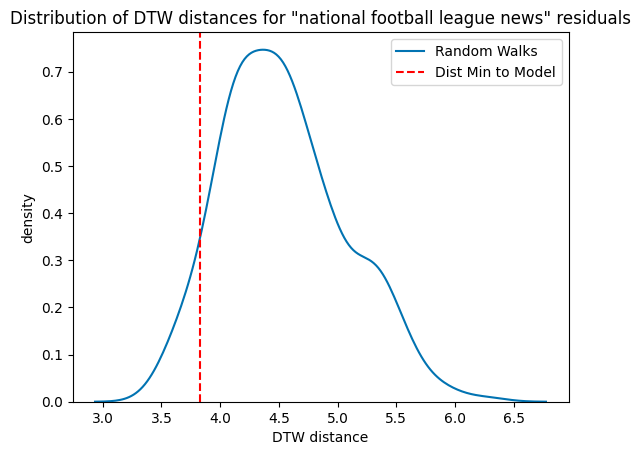

In [ ]:
# Plot distribution of DTW distances for random walks
sns.kdeplot(results[word]['dtw_distances_random_walks'], label='Random Walks', color=sns.color_palette("colorblind")[0])

# # Plot distribution of DTW distances for normal paths
# sns.kdeplot(results[word]['dtw_distances_normal_paths'], label='Normal Paths', color=sns.color_palette("colorblind")[1])

plt.axvline(results[word]['min_dtw_distance'], linestyle='--', label='Dist Min to Model', color='r')

# Add title and labels
plt.title(f'Distribution of DTW distances for "{word}" residuals')
plt.xlabel('DTW distance')
plt.ylabel('density')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PLOT for PAPER

In [ ]:
for word in results.keys():
    results[word]['25_p'] = np.percentile(results[word]['dtw_distances_random_walks'], 25)

In [ ]:
# fraction of words that are closer to model than to random walks
counter = 0
for word in results.keys():
    if results[word]['min_dtw_distance'] < results[word]['25_p']:
        counter += 1
counter / len(results.keys())

0.6740442655935613

In [ ]:
# different marker for word if distance is close or far from model-distance
for word in results.keys():
    if results[word]['min_dtw_distance'] > results[word]['25_p']:
        results[word]['facecolor'] = 'empty'
    else:
        results[word]['facecolor'] = 'full'

In [ ]:
# for each word, consider all the distances from the random walks and compute the mean
for word in results.keys():
    results[word]['avg_dtw_random_walks'] = np.mean(results[word]['dtw_distances_random_walks'])

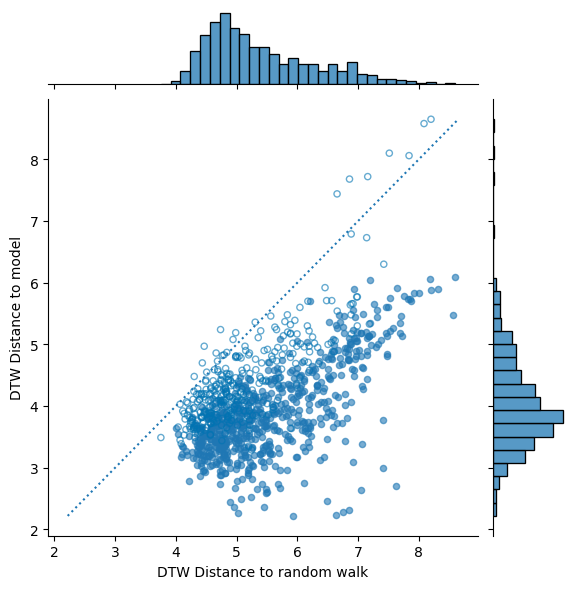

In [ ]:
# Create a DataFrame from the results dictionary
df_results = pd.DataFrame.from_dict(results, orient='index')

# Create a scatterplot with marginal histograms using seaborn
g = sns.jointplot(x='avg_dtw_random_walks', y='min_dtw_distance', data=df_results, kind='scatter', s=0, marginal_kws=dict(bins=30, fill=True))

# Get unique markers from your results and plot each category separately
x_values = [results[word]['avg_dtw_random_walks'] for word in results.keys() if results[word]['facecolor'] == 'full']
y_values = [results[word]['min_dtw_distance'] for word in results.keys() if results[word]['facecolor'] == 'full']
plt.scatter(x_values, y_values, s=20, alpha=0.6)

# Get unique markers from your results and plot each category separately
x_values = [results[word]['avg_dtw_random_walks'] for word in results.keys() if results[word]['facecolor'] == 'empty']
y_values = [results[word]['min_dtw_distance'] for word in results.keys() if results[word]['facecolor'] == 'empty']
plt.scatter(x_values, y_values, s=20, alpha=0.6, facecolor='none', edgecolor=sns.color_palette("colorblind")[0])


# Add a diagonal line (45-degree line)
min_val = min(df_results['min_dtw_distance'].min(), df_results['avg_dtw_random_walks'].min())
max_val = max(df_results['min_dtw_distance'].max(), df_results['avg_dtw_random_walks'].max())

# Plot the diagonal on the main scatter plot
g.ax_joint.plot([min_val, max_val], [min_val, max_val], ':')

# Set the labels and title
g.set_axis_labels('DTW Distance to random walk', 'DTW Distance to model')

plt.show()